In [ ]:
# composite_img <- img %>%
#   image_channel(channel = "blue") %>%
#   image_morphology(method = "Erode", kernel = "Disk") %>%
#   image_morphology(method = "Dilate", kernel = "Disk") %>%
#   image_fuzzycmeans() %>%
#   image_otsu() %>%
#   image_connect() %>%
#   image_split(keep_color = FALSE)  %>%
#   image_composite(img, operator = "Out")

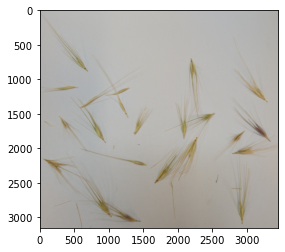

In [35]:
import cv2
from skimage.color import rgb2gray
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage

start_image = plt.imread("data/critesion murinum.jpg")

plt.imshow(start_image)

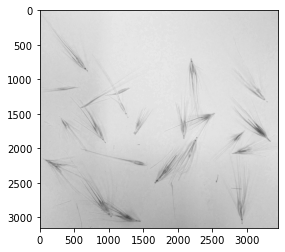

In [36]:
from numba import jit
import numpy as np

@jit(nopython=True)
def rgb_to_gray(img):
  x_dim = img.shape[1]
  y_dim = img.shape[0]
  return(np.array([[ img[y][x][0] for x in range(x_dim) ] for y in range(y_dim)]))

def remove_shadows(img, norm=True):
  rgb_planes = cv2.split(img)

  result_planes = []

  for plane in rgb_planes:
      dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
      bg_img = cv2.medianBlur(dilated_img, 21)
      diff_img = 255 - cv2.absdiff(plane, bg_img)

      # normalise if set
      if norm:
        diff_img = cv2.normalize(
            diff_img,
            None,
            alpha=0,
            beta=255,
            norm_type=cv2.NORM_MINMAX,
            dtype=cv2.CV_8UC1)

      result_planes.append(diff_img)

  return cv2.merge(result_planes)

gray_img = rgb_to_gray(start_image)
plt.imshow(gray_img, cmap="gray")

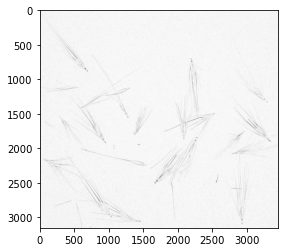

In [37]:
no_shadow = remove_shadows(gray_img)

plt.imshow((no_shadow), cmap="gray")

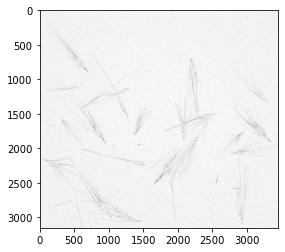

In [38]:
eroded = cv2.erode(no_shadow, np.ones((5,5), np.uint8))
dilated = cv2.dilate(eroded, np.ones((5,5), np.uint8))

plt.imshow(dilated, cmap="gray")

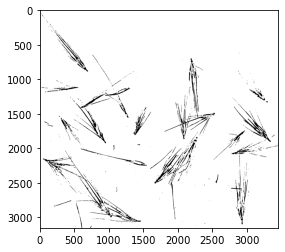

In [39]:
blurred = cv2.GaussianBlur(dilated, (5,5), 0)
otsu_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

plt.imshow(otsu_mask, cmap="gray")